# Execution example of DAG learning with the transitive closure over semirings

In [191]:
from neurips_experiments.data import data_generation
from neurips_experiments.evaluation.evaluation import count_accuracy, rc_approximation
from transitive_closure.transitive_closure import transitive_closure_dag, transitive_reduction_weighted, transitive_reduction_weighted_with_correction
from sparserc.sparserc import sparserc_solver
from transitive_closure.utils import remove_cyclic_edges_by_weight, visualize_dag, plot_matrix_distribution

import numpy as np
import time
import matplotlib.pyplot as plt


## Data generation via a linear SEM with few root causes

In [192]:
# first we define the experimental setup

# random graph parameters
d = 100 # number of nodes of the graph
k = 4 # equal to average degree of the graph
graph_type = "ER" # Erdös-Renyi graphs
(a, b) = (0.1, 0.9) # bounds for the weights of the adjacency matrix
# => the graph will be transformed into a DAG by assigning a random order

# Data on the graph parameters
n = 5000 # number of data samples
sparsity = 0.1
noise_type = "gauss"
noise_std = 0.01
noise_effect = "both"
semiring= 'max-times'
plot_graphs = False


# Execution parameters
sparserc_epochs = 10000 # for how many epochs we let SparseRC run
omega = 0.09

Text(0.5, 1.0, 'Weighted adjacency matrix')

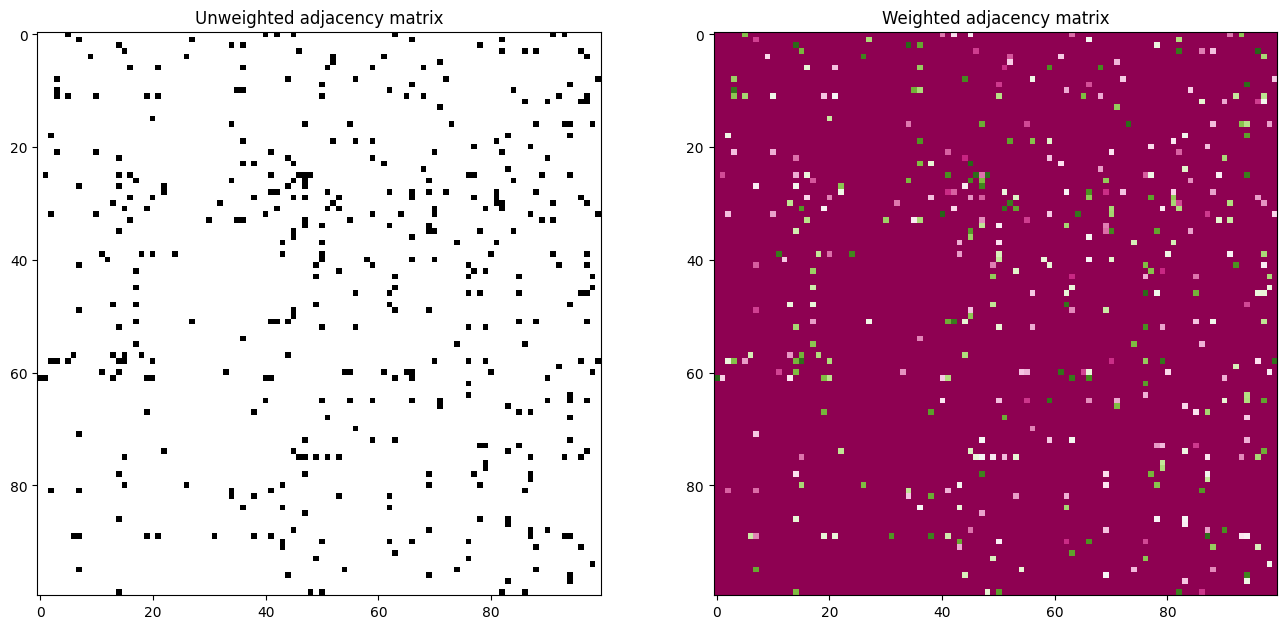

In [193]:
B_true = data_generation.simulate_dag(d, k * d, graph_type) # Erdös-Renyi graph simulation with avg degree = k

# Initializing weights on the adjacency matrix

W_true = data_generation.simulate_parameter(B_true, w_ranges=((-b,-a), (a, b))) # sampling uniformly the weights
if semiring != 'plus-times':
    W_true = abs(W_true)


W_tc_true = transitive_closure_dag(W_true, semiring)
W_tr_true = transitive_reduction_weighted(W_tc_true, semiring)
W_pt_true = transitive_reduction_weighted(W_tc_true, semiring="plus-times")


if d <= 50 and plot_graphs:
    print("Original graph:")
    visualize_dag(W_true)
    print("True Transitive closure:")
    visualize_dag(W_tc_true)
    plot_matrix_distribution(W_tc_true)
    print("True Transitive closure:")
    visualize_dag(W_tr_true)
    print("True plus-times graph (linear sem):")
    visualize_dag( W_pt_true)
    plot_matrix_distribution(W_pt_true)



# Visualizing the adjacency matrix
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 10)

ax1.imshow(B_true, cmap='Greys') # blue = non-zero
ax1.set_title('Unweighted adjacency matrix')

ax2.imshow(W_true, cmap='PiYG') # green = positive, pink = negative
ax2.set_title("Weighted adjacency matrix")

Text(0.5, 1.0, 'Data samples')

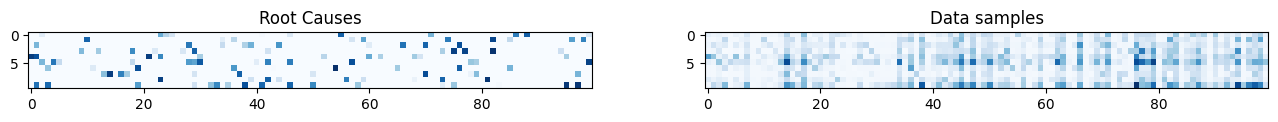

In [194]:
# Generate data
X, C_true, W_tc_true = data_generation.sparse_rc_sem(W_true, n, sparsity=sparsity, std=noise_std, 
                    noise_type=noise_type, noise_effect=noise_effect, semiring=semiring)

# Visualizing the root causes and the data 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 10)

# Picking the first 10 samples for visualiza^tion purposes
ax1.imshow(C_true[:10], cmap='Blues') # blue = non-zero
ax1.set_title('Root Causes')

ax2.imshow(X[:10], cmap='Blues') # green = positive, pink = zero
ax2.set_title("Data samples")

## Causal Discovery

In [195]:
# Retrieving the plus-times DAG adjacency matrix with SparseRC solver.

start = time.time()

# retrieving the weighted adjacency matrix of the plus-times DAG
W_pt_est = sparserc_solver(X, lambda1=0, lambda2=1, epochs=sparserc_epochs, omega=omega) 
# W_pt_est is thresholded: all entries with absolut value less than omega are set to 0.

T = time.time() - start

# Remove edges to make the graph a dag
W_pt_est, num_rem = remove_cyclic_edges_by_weight(W_pt_est)


Epoch: 0. Loss = 22.317
Epoch: 10. Loss = 14.425
Epoch: 20. Loss = 11.572
Epoch: 30. Loss = 10.427
Epoch: 40. Loss = 9.806
Epoch: 50. Loss = 9.263
Epoch: 60. Loss = 8.796
Epoch: 70. Loss = 8.390
Epoch: 80. Loss = 8.027
Epoch: 90. Loss = 7.702
Epoch: 100. Loss = 7.411
Epoch: 110. Loss = 7.148
Epoch: 120. Loss = 6.912
Epoch: 130. Loss = 6.698
Epoch: 140. Loss = 6.504
Epoch: 150. Loss = 6.327
Epoch: 160. Loss = 6.166
Epoch: 170. Loss = 6.018
Epoch: 180. Loss = 5.882
Epoch: 190. Loss = 5.756
Epoch: 200. Loss = 5.640
Epoch: 210. Loss = 5.532
Epoch: 220. Loss = 5.431
Epoch: 230. Loss = 5.337
Epoch: 240. Loss = 5.249
Epoch: 250. Loss = 5.167
Epoch: 260. Loss = 5.089
Epoch: 270. Loss = 5.016
Epoch: 280. Loss = 4.948
Epoch: 290. Loss = 4.883
Epoch: 300. Loss = 4.821
Epoch: 310. Loss = 4.764
Epoch: 320. Loss = 4.709
Epoch: 330. Loss = 4.656
Epoch: 340. Loss = 4.607
Epoch: 350. Loss = 4.560
Epoch: 360. Loss = 4.515
Epoch: 370. Loss = 4.472
Epoch: 380. Loss = 4.431
Epoch: 390. Loss = 4.392
Epoch: 

## Evaluation

Text(0.5, 1.0, 'TC SparseRC (weighted)')

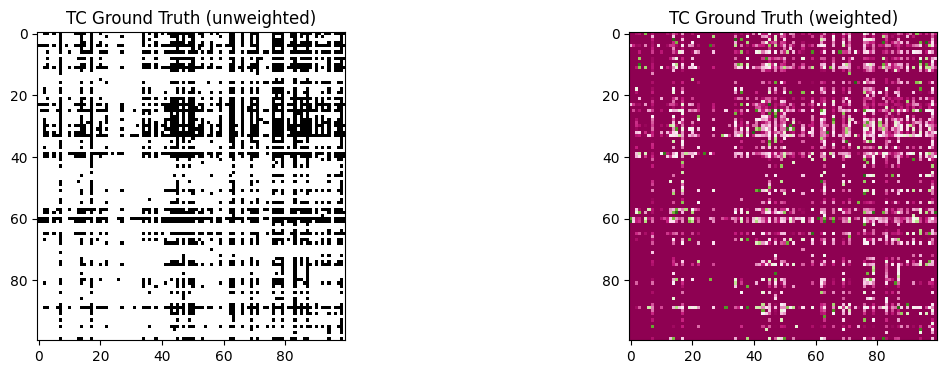

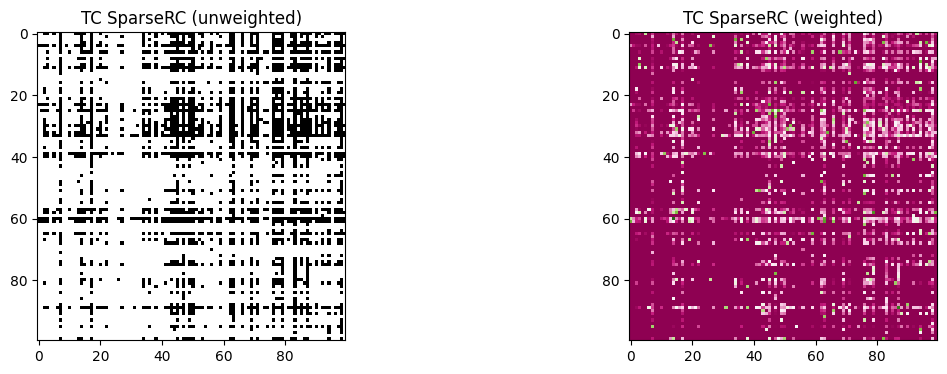

In [196]:

W_tc_est = transitive_closure_dag(W_pt_est, semiring= "plus-times")
W_tr_est = transitive_reduction_weighted_with_correction(W_tc_est, semiring, correction="plus")

# adjacency matrices
B_pt_est = W_pt_est != 0
B_pt_true = W_pt_true != 0

B_tc_est = W_tc_est != 0
B_tc_true = W_tc_true != 0

B_tr_est = W_tr_est != 0 
B_tr_true = W_tr_true != 0


# transitive closure
vmax = max(W_tc_true.max(), W_tc_est.max())


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 4)

ax1.imshow(B_tc_true, cmap='Greys') # black = non-zero
ax1.set_title('TC Ground Truth (unweighted)')

ax2.imshow(W_tc_true, cmap='PiYG',) # green = positive, pink = negative
ax2.set_title('TC Ground Truth (weighted)')


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 4)

ax1.imshow(B_tc_est, cmap='Greys') # black = non-zero
ax1.set_title('TC SparseRC (unweighted)')

ax2.imshow(W_tc_est, cmap='PiYG',) # green = positive, pink = negative
ax2.set_title('TC SparseRC (weighted)')

TP = 44238, P = 50084, FP = 530, N = 449916
SparseRC performance evaluation
Data on graph with 100 nodes and consisting of 5000 samples
Total runtime of sparserc was 4.8


----- Trans. Closure Graph Metrics -------
Structural Hamming Distance 0.000
Total edges proposed 2281.000
False Discovery Rate 0.000
True Positive Rate 1.000
Normalized mean-square error on approximation of the transitive closure: 0.146


----- Trans. Red. Graph Metrics -------
Structural Hamming Distance 82.000
Total edges proposed 412.000
False Discovery Rate 0.153
True Positive Rate 0.948
Normalized mean-square error on approximation of the transitive reduction: 0.345


----- Trans. closure of Red. Graph Metrics -------
Structural Hamming Distance 0.000
Total edges proposed 2281.000
False Discovery Rate 0.000
True Positive Rate 1.000
Normalized mean-square error on approximation of the transitive closure of the trans. reduction: 0.142


----- Graph Metrics -------
Structural Hamming Distance 522.000
Total edges p

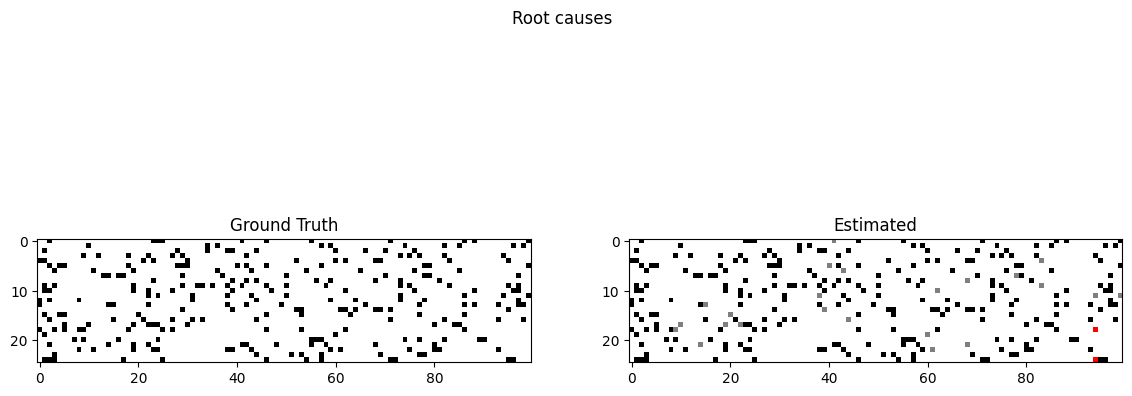

In [197]:
# Computing the performance metrics 
metrics = count_accuracy(B_pt_true, B_pt_est)
nmse = np.linalg.norm(W_pt_est - W_pt_true) / np.linalg.norm(W_pt_true)
                  
tc_metrics = count_accuracy(B_tc_true, B_tc_est)
tc_nmse = np.linalg.norm(W_tc_est - W_tc_true) / np.linalg.norm(W_tc_true)


tr_metrics = count_accuracy(B_tr_true, B_tr_est)
tr_nmse = np.linalg.norm(W_tr_est - W_tr_true) / np.linalg.norm(W_tr_true)

W_tc_tr_est = transitive_closure_dag(W_tr_est,  semiring)
B_tc_tr_est = W_tc_tr_est != 0

tc_tr_metrics = count_accuracy(B_tc_true, B_tc_tr_est)
tc_tr_nmse = np.linalg.norm(W_tc_tr_est - W_tc_true) / np.linalg.norm(W_tc_true)

# Evaluating the approximation of the root causes 
rc_nmse, support_tpr, support_fpr = rc_approximation(X, W_pt_est, C_true, semiring)
# visualizing first 25 root causes samples vs approximation.

print("SparseRC performance evaluation")
print("Data on graph with {} nodes and consisting of {} samples".format(d,n))
print("Total runtime of sparserc was {:.1f}".format(T))
print("\n")
print("----- Trans. Closure Graph Metrics -------")
print("Structural Hamming Distance {:.3f}".format(tc_metrics["shd"]))
print("Total edges proposed {:.3f}".format(tc_metrics["nnz"]))
print("False Discovery Rate {:.3f}".format(tc_metrics["fdr"]))
print("True Positive Rate {:.3f}".format(tc_metrics["tpr"]))
print("Normalized mean-square error on approximation of the transitive closure: {:.3f}".format(tc_nmse))
print("\n")
print("----- Trans. Red. Graph Metrics -------")
print("Structural Hamming Distance {:.3f}".format(tr_metrics["shd"]))
print("Total edges proposed {:.3f}".format(tr_metrics["nnz"]))
print("False Discovery Rate {:.3f}".format(tr_metrics["fdr"]))
print("True Positive Rate {:.3f}".format(tr_metrics["tpr"]))
print("Normalized mean-square error on approximation of the transitive reduction: {:.3f}".format(tr_nmse))
print("\n")
print("----- Trans. closure of Red. Graph Metrics -------")
print("Structural Hamming Distance {:.3f}".format(tc_tr_metrics["shd"]))
print("Total edges proposed {:.3f}".format(tc_tr_metrics["nnz"]))
print("False Discovery Rate {:.3f}".format(tc_tr_metrics["fdr"]))
print("True Positive Rate {:.3f}".format(tc_tr_metrics["tpr"]))
print("Normalized mean-square error on approximation of the transitive closure of the trans. reduction: {:.3f}".format(tc_tr_nmse))
print("\n")
print("----- Graph Metrics -------")
print("Structural Hamming Distance {:.3f}".format(metrics["shd"]))
print("Total edges proposed {:.3f}".format(metrics["nnz"]))
print("False Discovery Rate {:.3f}".format(metrics["fdr"]))
print("True Positive Rate {:.3f}".format(metrics["tpr"]))
print("Normalized mean-square error on approximation of weighted adjacency {:.3f}".format(nmse))
print("\n")
print("----- Root causes metrics -------")
print("Normalized mean-square error on approximation of root causes {:.3f}".format(rc_nmse))
print("True Positive Rate on the root causes support {:.3f}".format(support_tpr))
print("False Positive Rate on the root causes support {:.3f}".format(support_fpr))